# Ford GoBike Trip Data Trends
## by Oluwaseyi SALAMI

## Investigation Overview

I explored trip parameters with respect to the time of day and day of the week and looked at the average trip duration and age to observe patterns that apply to particular user types and gender.

## Dataset Overview

The dataset, after cleaning, contains info about 174,000+ rides that occured in February 2019. Each ride has features/characteristics recorded in 16 columns. These features include the ride duration in seconds, trip start and end times, start and end/destination station, station location and other info about bike users as well as whether the trip was shared.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
rides = pd.read_csv('201902-fordgobike-tripdata.csv')

### Clean data

In [3]:
# Copy original data
rides_clean = rides.copy()

# Remove rows with missing data in the `_station_id` and `member_gender` columns
station_gender_bool = (rides_clean.member_gender.notna()) & (rides_clean.start_station_id.notna())
rides_clean = rides_clean[station_gender_bool]

# Change `_time` columns to the datetime datatype
for col in ['start_time', 'end_time']:
    rides_clean[col] = pd.to_datetime(rides_clean[col])

# Change '_id' columns to the string/object datatype
for col in ['start_station_id', 'end_station_id', 'bike_id']:
    rides_clean[col] = rides_clean[col].astype('int').astype('str')

# Change birth year values to integers
rides_clean['member_birth_year'] = rides_clean.member_birth_year.astype('int')

# Give columns more descriptive names
rides_clean.rename(columns={'member_birth_year': 'user_birth_year',
                            'member_gender': 'user_gender',
                            'bike_share_for_all_trip': 'is_shared_trip'},
                   inplace=True)

# Change gender and user type columns to the category data type
for col in ['user_type', 'user_gender']:
    rides_clean[col] = rides_clean[col].astype('category')

# Remove rows where age is greater than 80 or trip duration is greater than 3 hours
age_or_duration_bool = (rides_clean.user_birth_year > 1940) & (rides_clean.duration_sec < 10800)
rides_clean = rides_clean[age_or_duration_bool]

In [4]:
# Set a default figure size
plt.rcParams['figure.figsize'] = (9,5)

# Function to add labels and titles.
def add_labels(title='', xlabel='', ylabel='', tsize=16):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=tsize)

# Add a 'duration_minute' column
rides_clean['duration_minute'] = (pd.to_timedelta(rides_clean.duration_sec, unit='s')\
                                  .dt.seconds / 60).round(2)

## Trip duration distribution

Most trips are short (< 50 minutes) with majority of trips lasting less than 25 minutes resulting in a long tail; a right-skewed distribution. After log-scaling trip duration in seconds, we see a more symmetrical distribution. However, there are still extreme values to the right. These outliers may be a result of inaccurate data and could be investigated later.

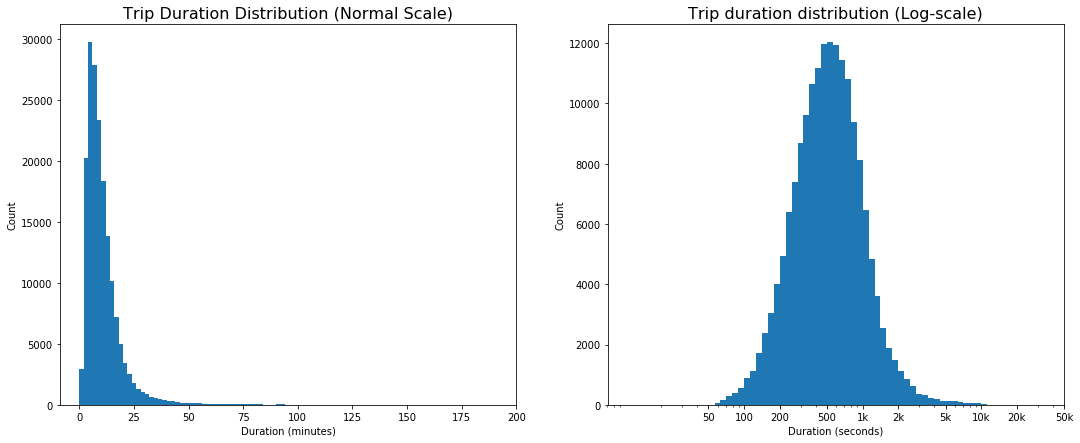

In [28]:
minute_bins = np.arange(0, rides_clean.duration_minute.max()+2, 2)
minute_labels = ['Trip Duration Distribution (Normal Scale)', 'Duration (minutes)', 'Count']
log_labels = ['Trip duration distribution (Log-scale)', 'Duration (seconds)', 'Count']


plt.figure(figsize=(18,7))
base_color = sns.color_palette()[0]

plt.subplot(121)
plt.hist('duration_minute', data=rides_clean, bins=minute_bins)
add_labels(*minute_labels)
plt.xlim(xmax=200)

plt.subplot(122)
bins = 10 ** np.arange(1, np.log10(rides_clean.duration_sec.max())+0.05, 0.05)
plt.hist('duration_sec', data=rides_clean, bins=bins)
plt.xscale('log')
plt.xticks([50,100, 200, 500, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4],
           [50, 100, 200, 500, '1k', '2k', '5k', '10k', '20k', '50k'])
add_labels(*log_labels);

In [6]:
# Create 'hour' and 'weekday' columns
rides_clean['start_hour'] = rides_clean.start_time.dt.hour
rides_clean['weekday'] = rides_clean.start_time.dt.weekday_name

# Change the 'weekday' column to an ordered categorical datatype
weekday_dict = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                'Saturday', 'Sunday']
weekday_cat = pd.api.types.CategoricalDtype(ordered=True,
                                            categories=weekday_dict)
rides_clean['weekday'] = rides_clean.weekday.astype(weekday_cat)

## Hourly and weekday trip distribution

There are two peaks in trip volume during the day; early morning and late afternoon. These correspond to the times people commute to and from work. Few trips are taken at night as expected. Thursdays have the highest trip volume with weekends seeing less than half of the trips taken on Thursdays.

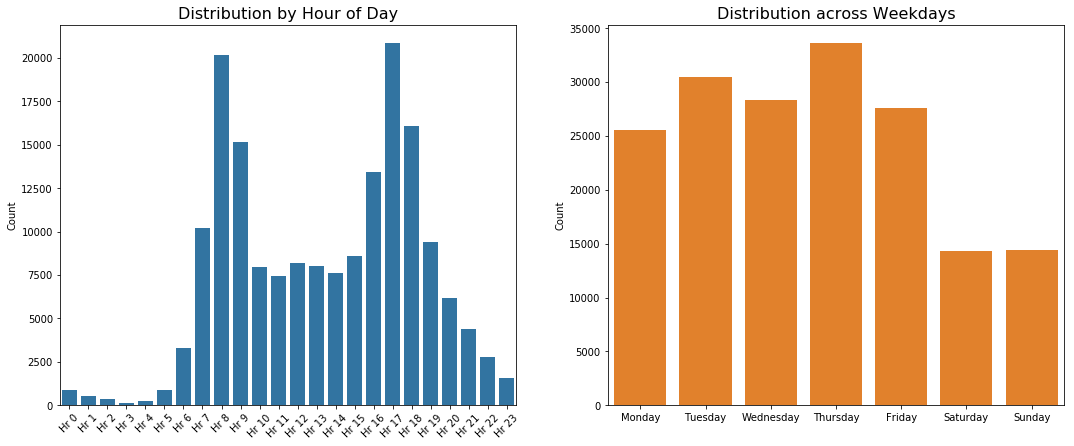

In [31]:
plt.figure(figsize=(18,7))

# View distribution of trips by hour
labels = ['Distribution by Hour of Day', '', 'Count']

plt.subplot(121)
sns.countplot('start_hour', data=rides_clean, color=base_color)
add_labels(*labels)
ticks = plt.xticks()[0]
plt.xticks(ticks, ['Hr {}'.format(str(t)) for t in ticks], rotation=45);

# View distribution of trips by weekday
labels = ['Distribution across Weekdays', '', 'Count']
yellow = sns.color_palette()[1]

plt.subplot(122)
sns.countplot('weekday', data=rides_clean, color=yellow)
add_labels(*labels)

## Gender and user type distribution

More males and subscribers are represented in this dataset. About 10% of users are customers while the remaining 90% are subscribers.

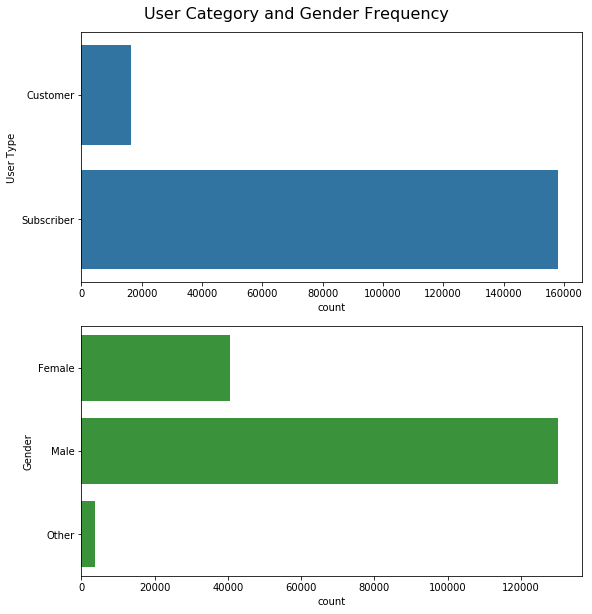

In [32]:
# View distributions of user/customer types, gender, and whether trips were shared
green = sns.color_palette()[2]
fig, ax = plt.subplots(nrows=2, figsize=(9,9))

sns.countplot(data=rides_clean, y='user_type', color=base_color, ax=ax[0]).set_ylabel('User Type')
sns.countplot(data=rides_clean, y='user_gender', color=green, ax=ax[1]).set_ylabel('Gender')
plt.suptitle('User Category and Gender Frequency', fontsize=16)
plt.tight_layout(pad=3.5, h_pad=1);

In [9]:
# Create an 'age' column
rides_clean['age'] = 2019 - rides_clean.user_birth_year

## Average trip duration by gender and average age by gender

Females have longer rides, on average, than males and are younger. Female riders are about 1-2 years younger than males and others.

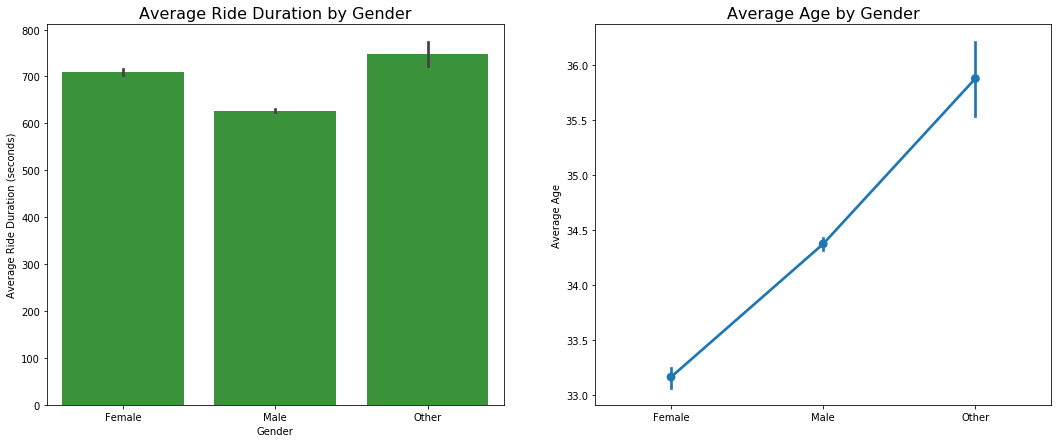

In [33]:
plt.figure(figsize=(18,7))

plt.subplot(121)
sns.barplot(x='user_gender', y='duration_sec', data=rides_clean, color=green)
add_labels(title='Average Ride Duration by Gender', xlabel='Gender',
           ylabel='Average Ride Duration (seconds)')

plt.subplot(122)
sns.pointplot(x='user_gender', y='age', data=rides_clean, color=base_color)
add_labels(title='Average Age by Gender', xlabel='',
           ylabel='Average Age');

## Average trip duration by user type and average age by user type

Customers do have longer rides; almost twice as much as subscribers. They are also slightly younger than subscribers

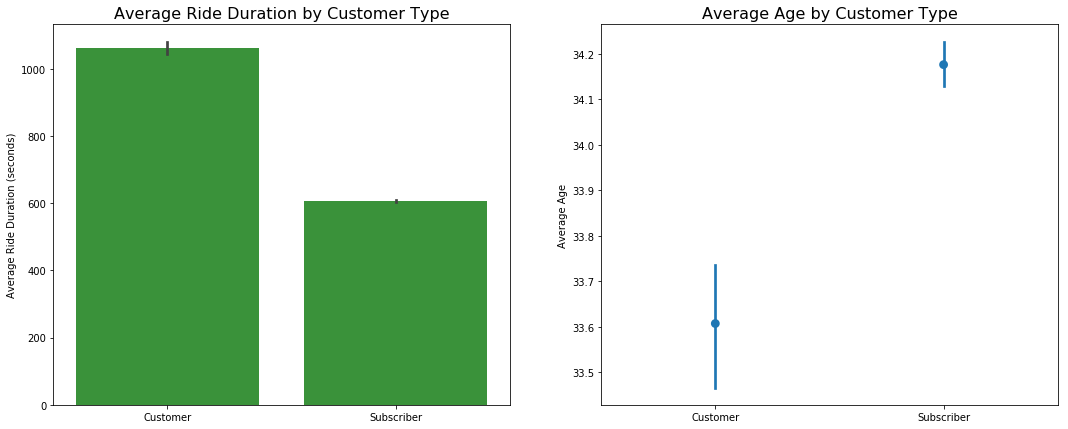

In [34]:
plt.figure(figsize=(18,7))

plt.subplot(121)
sns.barplot(x='user_type', y='duration_sec', data=rides_clean, color=green)
add_labels(title='Average Ride Duration by Customer Type', xlabel='',
           ylabel='Average Ride Duration (seconds)');

plt.subplot(122)
sns.pointplot(x='user_type', y='age', data=rides_clean, color=base_color, linestyles='')
add_labels(title='Average Age by Customer Type', xlabel='',
           ylabel='Average Age');

## Do female customers ride for longer? Are they younger?
Yes, they do have longer rides and are younger than males.

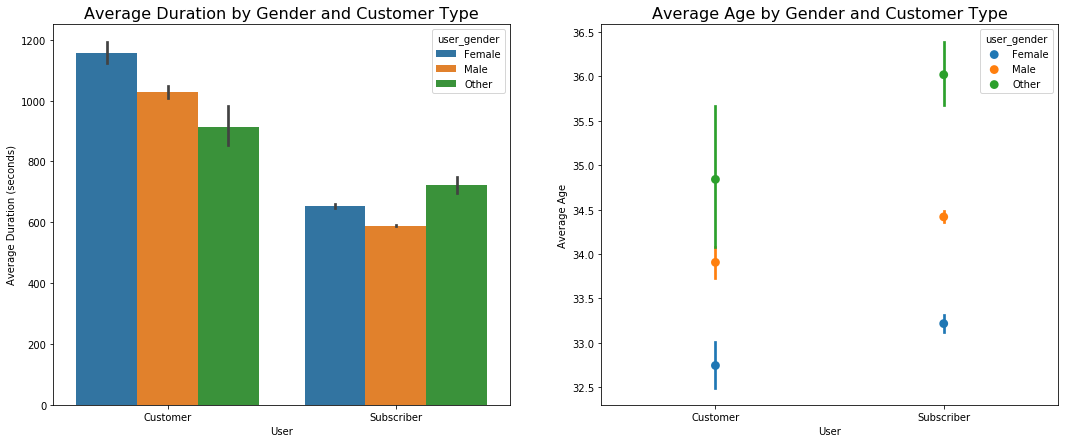

In [35]:
plt.figure(figsize=(18,7))

plt.subplot(121)
sns.barplot(x='user_type', y='duration_sec', hue='user_gender', data=rides_clean)
add_labels(title='Average Duration by Gender and Customer Type', xlabel='User',
           ylabel='Average Duration (seconds)');

plt.subplot(122)
sns.pointplot(x='user_type', y='age', hue='user_gender', data=rides_clean,
             linestyles='')
add_labels(title='Average Age by Gender and Customer Type', xlabel='User',
           ylabel='Average Age');

### Generate Slideshow

In [38]:
# Use this command if you are running this file in local
!jupyter nbconvert Ford_GoBike_Exploration_II.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Ford_GoBike_Exploration_II.ipynb to slides
[NbConvertApp] Writing 455516 bytes to Ford_GoBike_Exploration_II.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Ford_GoBike_Exploration_II.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg